In [1]:
from JupyterImport import *
root_logger.setLevel(logging.WARNING)

In [2]:
# dats = get_dats(range(155, 167+1), progress=True)  # With HQPC in first Plateau, base temp -- Probably gamma broadened...
# dats = get_dats(range(350, 362+1), progress=True)  # With HQPC in first Plateau , 100mK
# dats = get_dats(range(549, 561+1))  # Hardly any heating here
dats = get_dats(range(562, 574+1))  # Trying above again


100% (13 of 13) |########################| Elapsed Time: 0:00:07 Time:  0:00:07


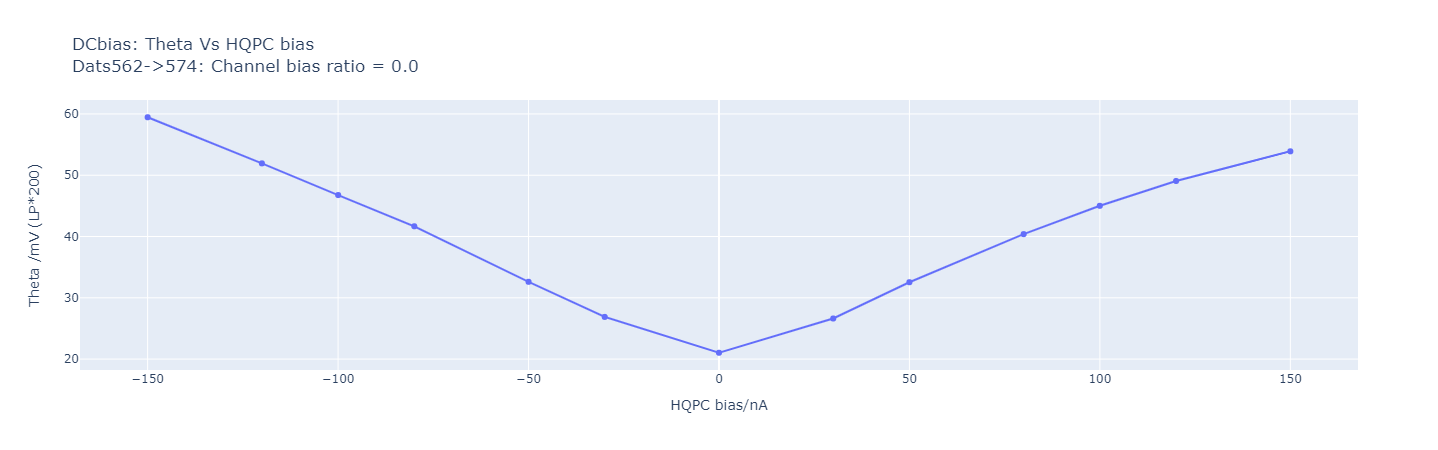

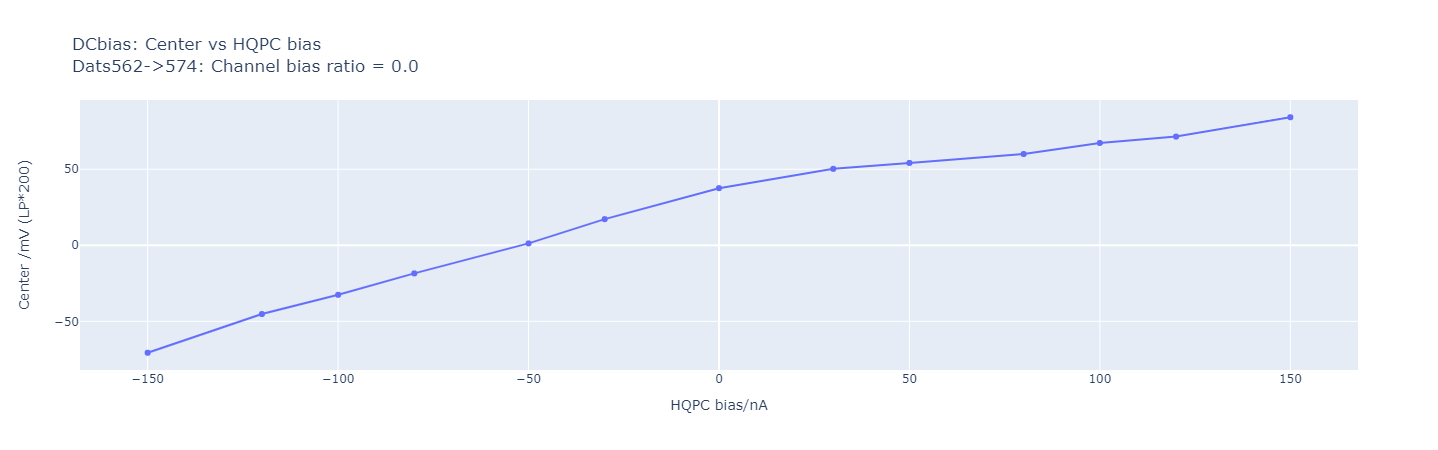

In [3]:
# data_key = 'theta'
# ylabel = 'Theta /mV (LP*200)'
hqpc_biases = set([round(dat.Logs.fds['R2T(10M)']) for dat in dats])

for data_key, ylabel, title, fname in zip(['theta', 'mid'], ['Theta /mV (LP*200)', 'Center /mV (LP*200)'], ['DCbias: Theta Vs HQPC bias', 'DCbias: Center vs HQPC bias'], ['ThetaVsHPQC', 'CenterVsHQPC']):
    dat_chunks = np.flip(np.reshape(np.array(dats), (int(len(dats)/len(hqpc_biases)), -1)), axis=0)

    xs, datas, ids, titles = list(), list(), list(), list()
    # for ratio in ratios:
    for dat_chunk in dat_chunks:
    #     ds = [dat for dat in dats if round(dat.Logs.fds['TC/0.001']/dat.Logs.fds['R2T(10M)'], 2) == ratio]
        ds = dat_chunk

        ratio = round(np.mean([-1*dat.Logs.fds['TC/0.001']/dat.Logs.fds['R2T(10M)'] if not np.isclose(dat.Logs.fds['R2T(10M)'],0) else 0 for dat in ds]), 4)

        datas.append(np.array([getattr(dat.Transition.avg_fit.best_values, data_key) for dat in ds]))
        xs.append(np.array([dat.Logs.fds['R2T(10M)']/10 for dat in ds]))
        ids.append(ratio)
        titles.append(f'{title}<br>Dats{ds[0].datnum}->{ds[-1].datnum}: Channel bias ratio = {ratio}')

    fig = PlU.get_figure(datas, xs, ids=ids, titles=titles, labels=None, xlabel='HQPC bias/nA', ylabel=ylabel, plot_kwargs={'mode':'lines+markers'})
#     fig.write_html(export_path+f'Dats{dats[0].datnum}-{dats[-1].datnum}{fname}.html')
    fig.show()

<ipython-input-6-a68621e8f2c1>:18: RuntimeWarning:

divide by zero encountered in double_scalars



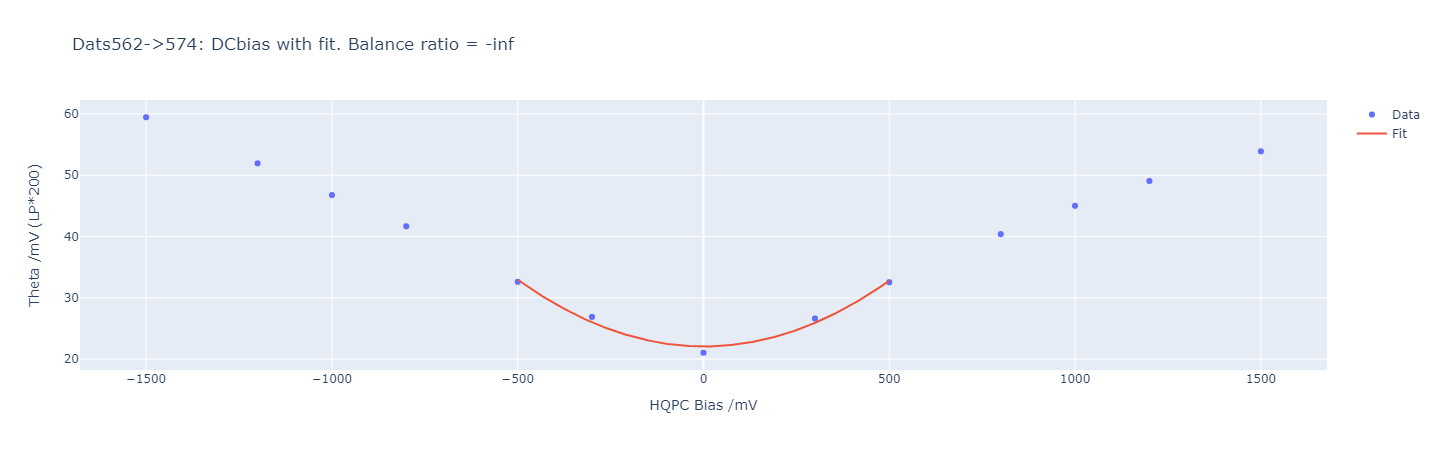

In [6]:

thetas = [dat.Transition.avg_fit.best_values.theta for dat in dats]
bias = [dat.Logs.fds['R2T(10M)'] for dat in dats]

idxs = CU.get_data_index(bias, [-500, 500])

quad = lm.models.QuadraticModel()
pars = quad.make_params()
pars['b'].value = 0
pars['b'].vary = True
ftheta = thetas[idxs[0]:idxs[1]+1]
fbias= bias[idxs[0]:idxs[1]+1]
fit = quad.fit(ftheta, x=fbias, params=pars)

fig = go.Figure()
fig.add_trace(go.Scatter(x=bias, y=thetas, name='Data', mode='markers'))
x = np.linspace(fbias[0], fbias[-1], 1000)
fig.add_trace(go.Scatter(x=x, y=fit.eval(x=x), name='Fit', mode='lines'))
fig.update_layout(xaxis_title='HQPC Bias /mV', yaxis_title='Theta /mV (LP*200)', title=f'Dats{dats[0].datnum}->{dats[-1].datnum}: DCbias with fit. Balance ratio = {dats[0].Logs.fds["R2T(10M)"]/dats[0].Logs.fds["TC/0.001"]:.4f}')
# fig.write_html(export_path+f'Dats{dats[0].datnum}-{dats[-1].datnum}DCbiasWithFit.html')
fig.show()

In [114]:
mids = [dat.Transition.avg_fit.best_values.mid for dat in dats]
bias = [dat.Logs.fds['R2T(10M)'] for dat in dats]

line = lm.models.LinearModel()

fit = line.fit(mids, x=bias)
print(fit.fit_report())
fit


[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 13
    # variables        = 2
    chi-square         = 37.5581225
    reduced chi-square = 3.41437477
    Akaike info crit   = 17.7922240
    Bayesian info crit = 18.9221227
[[Variables]]
    slope:      0.05816616 +/- 5.4876e-04 (0.94%) (init = 1)
    intercept: -8.94236321 +/- 0.51248825 (5.73%) (init = 0)


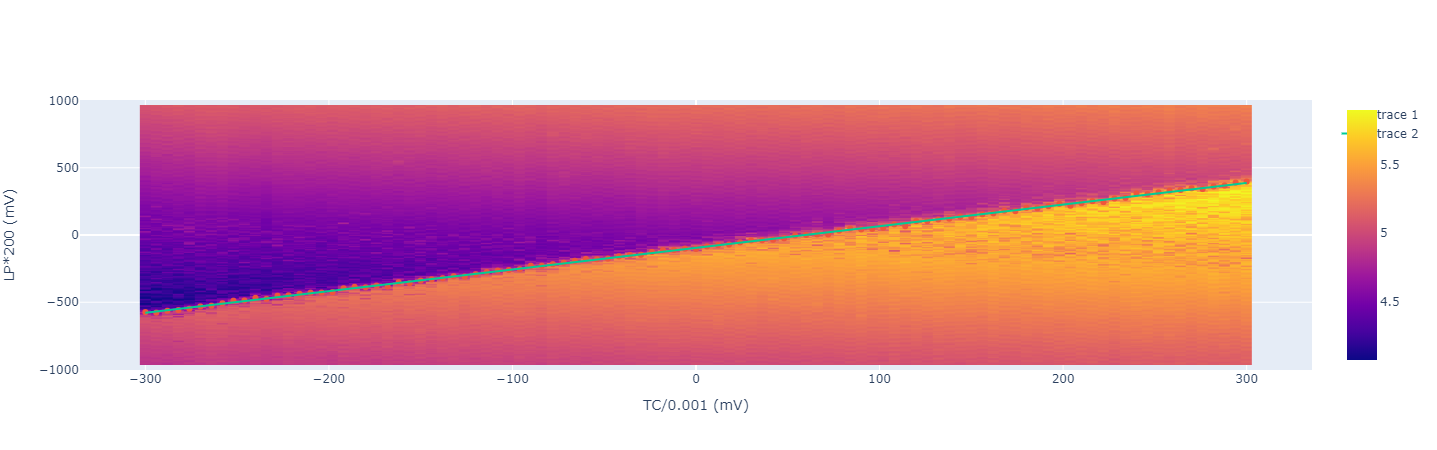

In [10]:
# dat = get_dat(367)  # First one
# dat = get_dat(575)  # With LCSS at -220, LCB at -670
# dat = get_dat(576)  # same as above different place with LCT = -400 instead of -430, should still be weakly coupled.
dat = get_dat(578)  # Same again with LCT = -460 this time (a bit pinched off)
 
decimate_factor = int(np.ceil(dat.Transition.data.shape[-1]/300))

fig = go.Figure()

data = CU.decimate(dat.Transition.data, dat.Logs.Fastdac.measure_freq, decimate_factor=decimate_factor).T

y = np.linspace(dat.Transition.x[0], dat.Transition.x[-1], data.shape[0]).astype(np.float32)
x = dat.Transition.y[:].astype(np.float32)

fig.add_trace(go.Heatmap(x=x, y=y, z=data))
fig.update_layout(yaxis_title=dat.Logs.x_label,
                  xaxis_title=dat.Logs.y_label)

mids = np.array([f.best_values.mid for f in dat.Transition.all_fits]).astype(np.float32)
fig.add_trace(go.Scatter(mode='markers', x=x, y=mids))

line = lm.models.LinearModel()
fit = line.fit(mids, x=x)

fig.add_trace(go.Scatter(mode='lines', x=x, y=fit.eval(x=x)))

fig

In [11]:
print(fit.fit_report())
fit

[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 14
    # data points      = 101
    # variables        = 2
    chi-square         = 6291.833
    reduced chi-square = 63.5538688
    Akaike info crit   = 421.320608
    Bayesian info crit = 426.550849
[[Variables]]
    slope:      1.60916191 +/- 0.00453451 (0.28%) (init = 1)
    intercept: -95.5864005 +/- 0.79332376 (0.83%) (init = 0)


In [48]:
# dat = get_dat(154)
# fig, axs = plt.subplots(1,2, figsize=(15, 8))
# axs = axs.flatten()

# ax = axs[0]
# data, f = CU.decimate(dat.Data.i_sense, dat.Logs.Fastdac.measure_freq, decimate_factor=30, return_freq=True)
# x = dat.Data.x_array
# x = np.linspace(x[0], x[-1], data.shape[-1])
# P.display_2d(x, dat.Data.y_array, data, ax, x_label=dat.Logs.x_label, y_label=dat.Logs.y_label)


# ax = axs[1]
# thetas = [f.best_values.theta for f in dat.Transition.all_fits]
# P.display_1d(dat.Data.y_array, thetas, ax, x_label=dat.Logs.y_label, y_label='Theta /mV', marker='+')

# fig.suptitle(f'Dat{dat.datnum}: Supposed to be DCbias at base temp')